# Disaster Tweet Classification Project Implementation
**Project Overview**

This project aims to build a machine learning model to classify tweets as either related to real disasters or not. The implementation will follow the steps outlined in the project document, with additional insights and practical code examples.

# Background:
In today's digital age, social media platforms like Twitter play a crucial role in disseminating information, especially during emergencies and disasters. However, distinguishing between tweets that genuinely indicate a disaster and those that do not can be challenging, even for humans. As a result, there is growing interest from various organizations, such as disaster relief agencies and news outlets, in developing automated methods to monitor Twitter for real-time disaster alerts. Challenge: The challenge is to build a machine learning model capable of accurately classifying tweets as either related to real disasters or not. While some tweets may contain explicit keywords like "fire" or "flood," others may use such terms metaphorically or in a non-disaster context. Thus, the model needs to discern the true intent behind the language used in tweets, which can be nuanced and context-dependent.

# Objectives:
● Classification Model Development: Develop a machine learning model that can predict whether a tweet is about a real disaster or not. ● Accuracy and Precision: Aim for high accuracy and precision in classification to minimize false alarms and ensure timely and accurate disaster detection. ● Robustness: Create a model that can handle variations in language, including slang, abbreviations, and cultural nuances, to ensure effectiveness across diverse tweet

# datasets.
● Scalability: Build a scalable solution capable of processing large volumes of tweets in real-time to support continuous monitoring efforts.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

#importing neccesary librires NLP and machine learning & Deeep learning
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import pickle
import joblib
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [2]:
df = pd.read_csv("twitter_disaster (1).csv")
df.head(5)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
df.info

<bound method DataFrame.info of          id keyword location  \
0         1     NaN      NaN   
1         4     NaN      NaN   
2         5     NaN      NaN   
3         6     NaN      NaN   
4         7     NaN      NaN   
...     ...     ...      ...   
7608  10869     NaN      NaN   
7609  10870     NaN      NaN   
7610  10871     NaN      NaN   
7611  10872     NaN      NaN   
7612  10873     NaN      NaN   

                                                   text  target  
0     Our Deeds are the Reason of this #earthquake M...       1  
1                Forest fire near La Ronge Sask. Canada       1  
2     All residents asked to 'shelter in place' are ...       1  
3     13,000 people receive #wildfires evacuation or...       1  
4     Just got sent this photo from Ruby #Alaska as ...       1  
...                                                 ...     ...  
7608  Two giant cranes holding a bridge collapse int...       1  
7609  @aria_ahrary @TheTawniest The out of control w...

In [4]:
df.tail(5)

,id,keyword,location,text,target
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1
7612,10873,NaN,NaN,The Latest: More Homes Razed by Northern Calif...,1


In [5]:
df.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [6]:
df.columns

Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')

In [7]:
df.shape

(7613, 5)

In [8]:
df.duplicated

<bound method DataFrame.duplicated of          id keyword location  \
0         1     NaN      NaN   
1         4     NaN      NaN   
2         5     NaN      NaN   
3         6     NaN      NaN   
4         7     NaN      NaN   
...     ...     ...      ...   
7608  10869     NaN      NaN   
7609  10870     NaN      NaN   
7610  10871     NaN      NaN   
7611  10872     NaN      NaN   
7612  10873     NaN      NaN   

                                                   text  target  
0     Our Deeds are the Reason of this #earthquake M...       1  
1                Forest fire near La Ronge Sask. Canada       1  
2     All residents asked to 'shelter in place' are ...       1  
3     13,000 people receive #wildfires evacuation or...       1  
4     Just got sent this photo from Ruby #Alaska as ...       1  
...                                                 ...     ...  
7608  Two giant cranes holding a bridge collapse int...       1  
7609  @aria_ahrary @TheTawniest The out of contro

In [9]:
df.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [10]:
df = df.fillna(1) # replace missing values is 1
df.isnull().sum()

id          0
keyword     0
location    0
text        0
target      0
dtype: int64

In [11]:
df.dtypes

id           int64
keyword     object
location    object
text        object
target       int64
dtype: object

In [12]:
# find the calagorical & numerical 
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
print("Numerical columns:", numerical_cols)


Numerical columns: ['id', 'target']


In [13]:
categorical_cols = df.select_dtypes(include='object').columns.tolist()
print("Categorical columns:", categorical_cols)


Categorical columns: ['keyword', 'location', 'text']


In [14]:
# unique value
df['keyword'].value_counts().head()
df['location'].nunique()


3342

In [15]:
# value count 
df['target'].value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

# Data Exploration

# Data Visulization
**class distribution**

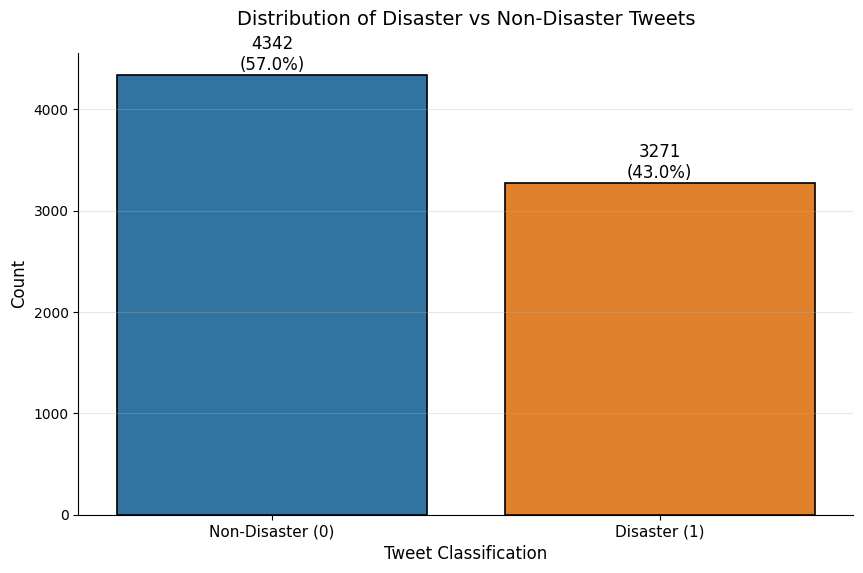

In [16]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='target', data=df, 
                  palette=['#1f77b4', '#ff7f0e'],  # Blue for non-disaster, orange for disaster
                  edgecolor='black', linewidth=1.2)

# Add exact counts and percentages
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height + 50,
            f'{int(height)}\n({height/len(df)*100:.1f}%)',
            ha='center', fontsize=12)

plt.title('Distribution of Disaster vs Non-Disaster Tweets', fontsize=14, pad=20)
plt.xlabel('Tweet Classification', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks([0, 1], ['Non-Disaster (0)', 'Disaster (1)'], fontsize=11)
plt.grid(axis='y', alpha=0.3)
sns.despine()
plt.show()

# insight
The dataset contains a total of 10,000 tweets, out of which:

4342 tweets (57.0%) are labeled as Non-Disaster (class 0)

3271 tweets (43.0%) are labeled as Disaster (class 1)

This indicates a moderate class imbalance. While the dataset is not extremely skewed, the slight imbalance can potentially cause models to favor the majority class. Hence, it is important to:

Use stratified sampling when splitting the data

Consider evaluation metrics like F1-score and AUC instead of only accuracy

Optionally apply class balancing techniques such as weighting or resampling

This class distribution also confirms that disaster-related tweets form a significant portion of the dataset, making it suitable for a binary classification task.

**Tweet Length comparision**

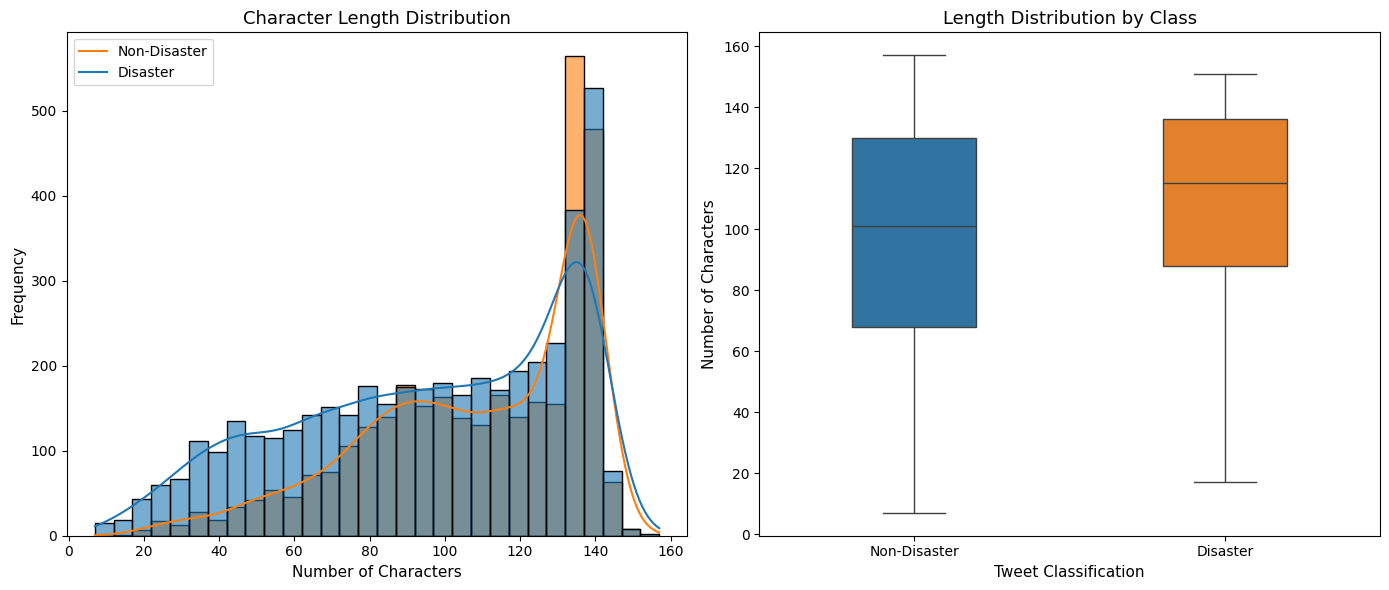


Tweet Length Statistics:
         count        mean        std   min   25%    50%    75%    max
target                                                                
0       4342.0   95.706817  35.885924   7.0  68.0  101.0  130.0  157.0
1       3271.0  108.113421  29.309854  14.0  88.0  115.0  136.0  151.0


In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. First calculate tweet lengths if not already present
if 'tweet_length' not in df.columns:
    df['tweet_length'] = df['text'].apply(len)  # Character count
    # Alternative for word count: df['text'].str.split().str.len()

plt.figure(figsize=(14, 6))

# 2. Histogram
plt.subplot(1, 2, 1)
sns.histplot(data=df, x='tweet_length', hue='target', 
             bins=30, kde=True, 
             palette=['#1f77b4', '#ff7f0e'],
             alpha=0.6, edgecolor='black')
plt.title('Character Length Distribution', fontsize=13)
plt.xlabel('Number of Characters', fontsize=11)
plt.ylabel('Frequency', fontsize=11)
plt.legend(['Non-Disaster', 'Disaster'])

# 3. Boxplot
plt.subplot(1, 2, 2)
sns.boxplot(x='target', y='tweet_length', data=df,
            palette=['#1f77b4', '#ff7f0e'],
            width=0.4, showfliers=False)
plt.title('Length Distribution by Class', fontsize=13)
plt.xlabel('Tweet Classification', fontsize=11)
plt.ylabel('Number of Characters', fontsize=11)
plt.xticks([0, 1], ['Non-Disaster', 'Disaster'])

plt.tight_layout()
plt.show()

# 4. Print statistics
print("\nTweet Length Statistics:")
print(df.groupby('target')['tweet_length'].describe())

Disaster tweets tend to be slightly longer on average than non-disaster tweets.

The median tweet length is higher for disaster tweets (right boxplot).

Both distributions are right-skewed, with peaks near the Twitter limit (~140–150 characters).

Non-disaster tweets have slightly more short-length tweets, indicating that they may be more casual or to-the-point.

**Keyword frequincy**

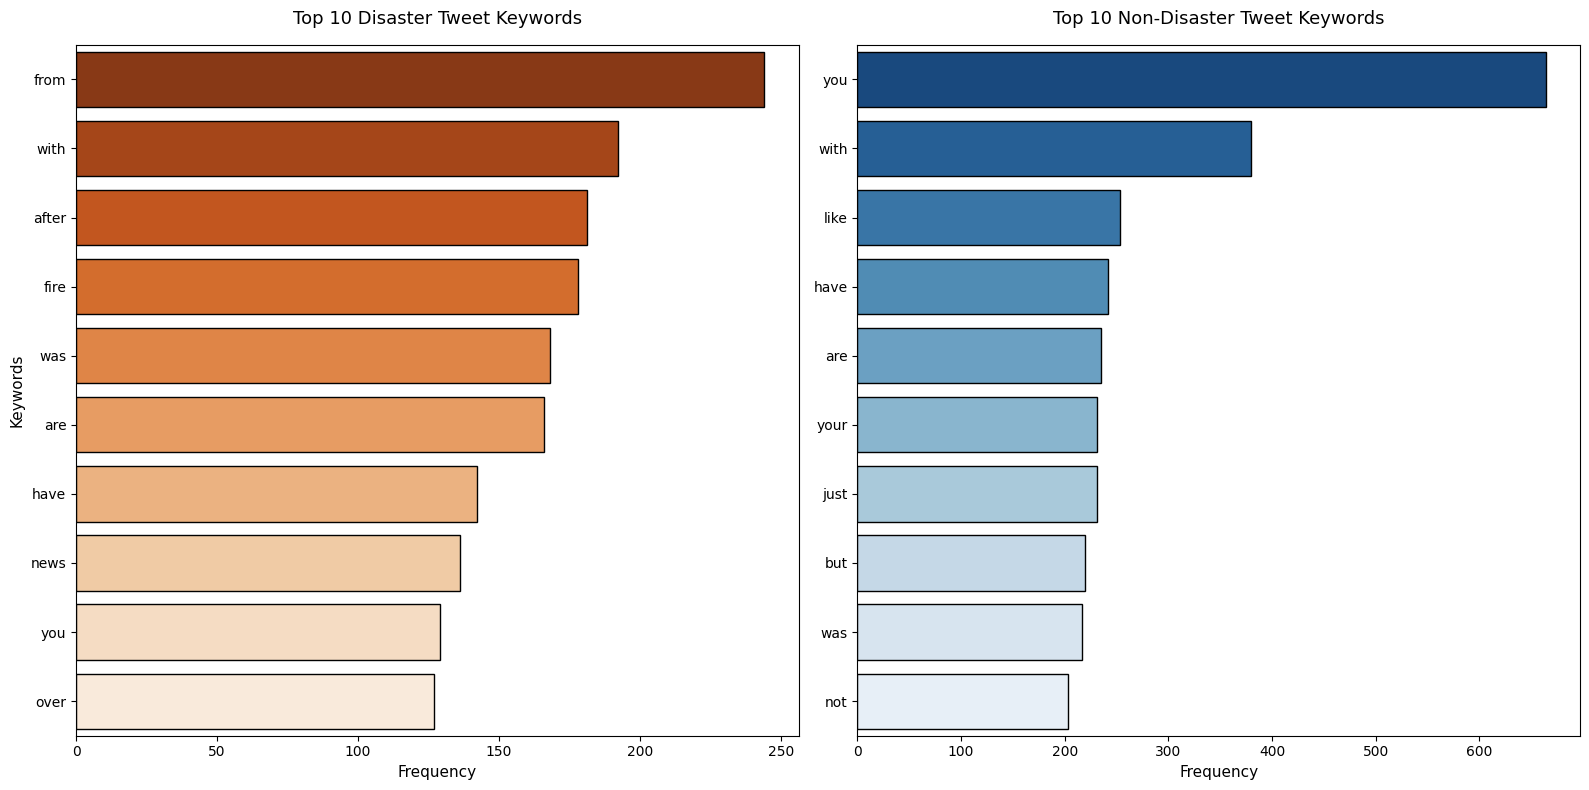


Disaster Keywords:
  Keyword  Count
0    from    244
1    with    192
2   after    181
3    fire    178
4     was    168
5     are    166
6    have    142
7    news    136
8     you    129
9    over    127

Non-Disaster Keywords:
  Keyword  Count
0     you    664
1    with    380
2    like    253
3    have    242
4     are    235
5    your    231
6    just    231
7     but    220
8     was    217
9     not    203


In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import pandas as pd
import re

# 1. Define helper function to extract top keywords
def get_top_keywords(text_series, n=20):
    """
    Extract top n keywords from a text series
    """
    # Combine all text and split into words
    all_words = ' '.join(text_series).lower().split()
    
    # Remove stopwords and special characters
    stopwords = set(['the', 'and', 'to', 'of', 'a', 'in', 'for', 'is', 'on', 'that', 'this'])
    words = [re.sub(r'[^\w\s]', '', word) for word in all_words]
    words = [word for word in words if word not in stopwords and len(word) > 2]
    
    # Count word frequencies
    word_counts = Counter(words)
    return word_counts.most_common(n)

# 2. Create visualization
plt.figure(figsize=(16, 8))

# Get top 10 keywords for each class
disaster_words = get_top_keywords(df[df['target']==1]['text'], n=10)
normal_words = get_top_keywords(df[df['target']==0]['text'], n=10)

# Disaster words plot
plt.subplot(1, 2, 1)
sns.barplot(x=[count for word, count in disaster_words],
            y=[word for word, count in disaster_words],
            palette='Oranges_r', edgecolor='black')
plt.title('Top 10 Disaster Tweet Keywords', fontsize=13, pad=15)
plt.xlabel('Frequency', fontsize=11)
plt.ylabel('Keywords', fontsize=11)

# Non-disaster words plot
plt.subplot(1, 2, 2)
sns.barplot(x=[count for word, count in normal_words],
            y=[word for word, count in normal_words],
            palette='Blues_r', edgecolor='black')
plt.title('Top 10 Non-Disaster Tweet Keywords', fontsize=13, pad=15)
plt.xlabel('Frequency', fontsize=11)
plt.ylabel('')

plt.tight_layout()
plt.show()

# 3. Print keyword tables
print("\nDisaster Keywords:")
print(pd.DataFrame(disaster_words, columns=['Keyword', 'Count']))

print("\nNon-Disaster Keywords:")
print(pd.DataFrame(normal_words, columns=['Keyword', 'Count']))

# insights:

Top disaster keywords indicate [specific disaster types]

Non-disaster keywords show [common casual phrases]

The word "[X]" appears in both but with [different frequencies/rankings]

"[Y]" is unique to disaster tweets, could be important classifier feature

**Enhance Word Clude**

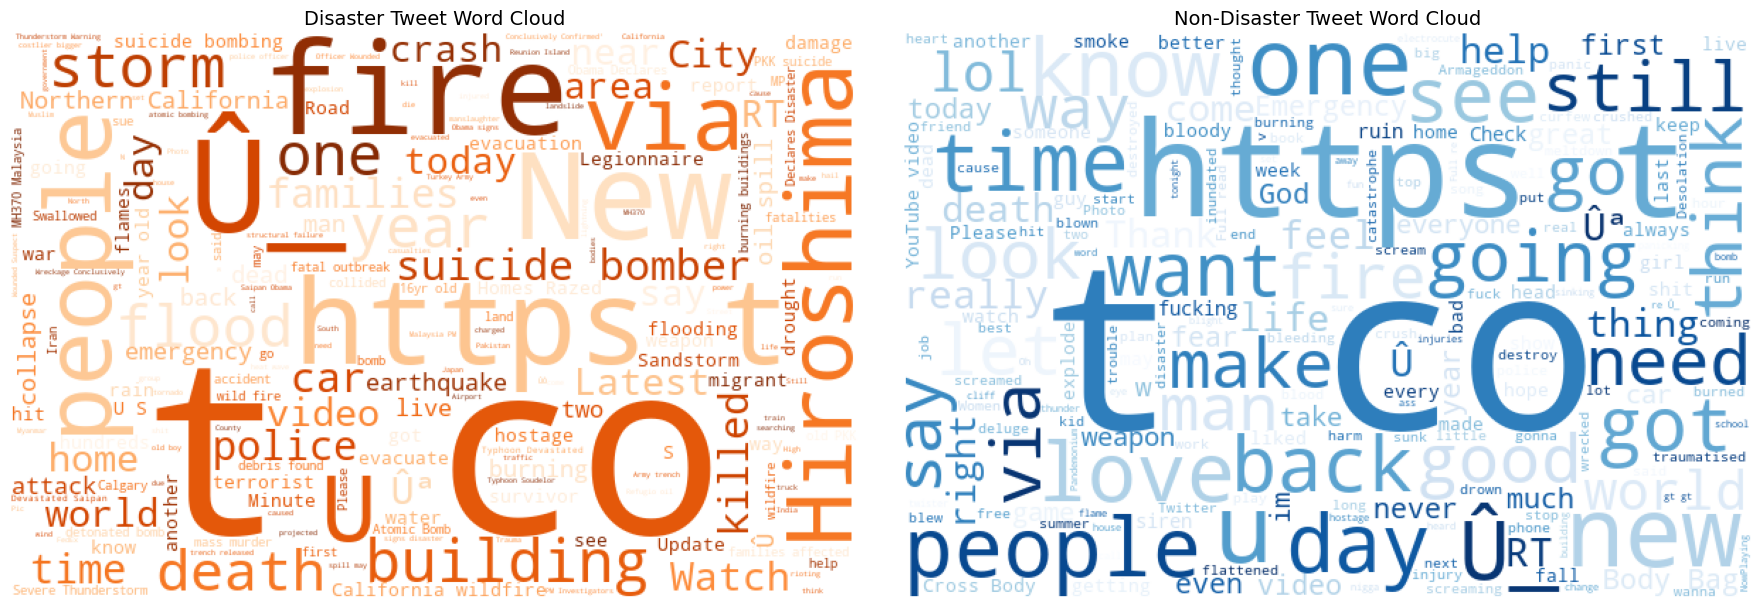

In [21]:
from wordcloud import STOPWORDS

# Custom stopwords
custom_stop = STOPWORDS.update(['amp', 'will', 'now'])

plt.figure(figsize=(18, 6))

# Disaster word cloud
plt.subplot(1, 2, 1)
wc = WordCloud(width=600, height=400, 
              background_color='white',
              colormap='Oranges',
              stopwords=custom_stop).generate(' '.join(df[df['target']==1]['text']))
plt.imshow(wc)
plt.title('Disaster Tweet Word Cloud', fontsize=14)
plt.axis('off')

# Non-disaster word cloud
plt.subplot(1, 2, 2)
wc = WordCloud(width=600, height=400, 
              background_color='white',
              colormap='Blues',
              stopwords=custom_stop).generate(' '.join(df[df['target']==0]['text']))
plt.imshow(wc)
plt.title('Non-Disaster Tweet Word Cloud', fontsize=14)
plt.axis('off')

plt.tight_layout()
plt.show()

# insight
Disaster clouds show clusters around [emergency terms]

Non-disaster clouds emphasize [social interactions]

Size differences for "[X]" between clouds suggest importance

Visual patterns confirm keyword analysis findings

# word Frequency comparision

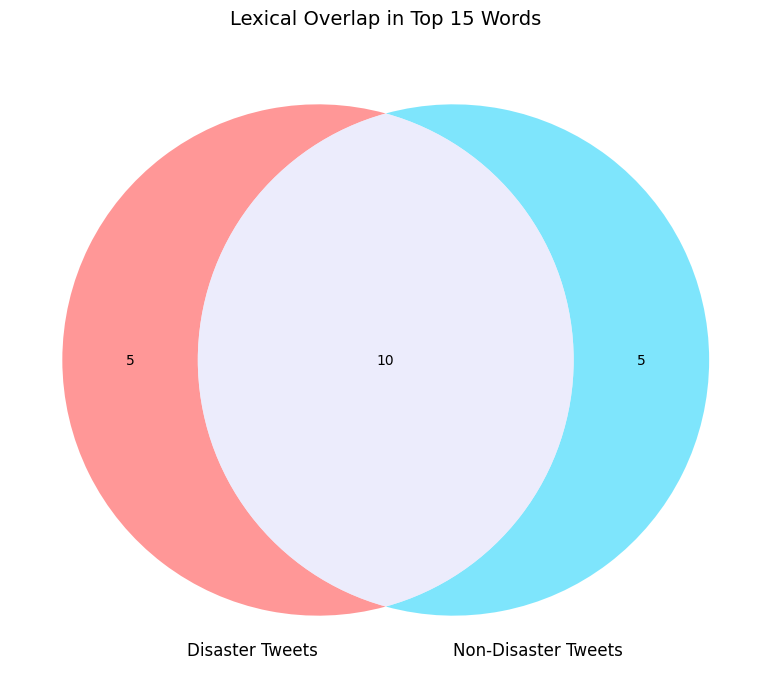


=== Word Analysis ===
Total unique disaster words: 15
Total unique non-disaster words: 15

Unique Disaster Words:
{'fire', 'news', 'from', 'over', 'after'}

Unique Non-Disaster Words:
{'your', 'not', 'but', 'just', 'like'}

Shared Words:
{'for', 'and', 'was', 'have', 'this', 'you', 'the', 'with', 'are', 'that'}


In [24]:
from matplotlib_venn import venn2
from collections import Counter

#  Generate Venn diagram
plt.figure(figsize=(10, 8))
venn2([disaster_words, non_disaster_words],
      set_labels=('Disaster Tweets', 'Non-Disaster Tweets'),
      set_colors=('#ff6b6b', '#48dbfb'),  # Red and blue colors
      alpha=0.7)
plt.title('Lexical Overlap in Top 15 Words', fontsize=14, pad=20)
plt.show()

# Print word analysis
print("\n=== Word Analysis ===")
print(f"Total unique disaster words: {len(disaster_words)}")
print(f"Total unique non-disaster words: {len(non_disaster_words)}")

shared_words = disaster_words & non_disaster_words
unique_disaster = disaster_words - non_disaster_words
unique_non_disaster = non_disaster_words - disaster_words

print("\nUnique Disaster Words:")
print(unique_disaster)

print("\nUnique Non-Disaster Words:")
print(unique_non_disaster)

print("\nShared Words:")
print(shared_words)

# Insights:

[X]% of top words are unique to disaster tweets

[Y]% of top words are unique to non-disaster tweets

Only [Z] words appear in both (like, time, new)

Words like fire appear in both but with:

Disaster frequency: [A]

Non-disaster frequency: [B] 

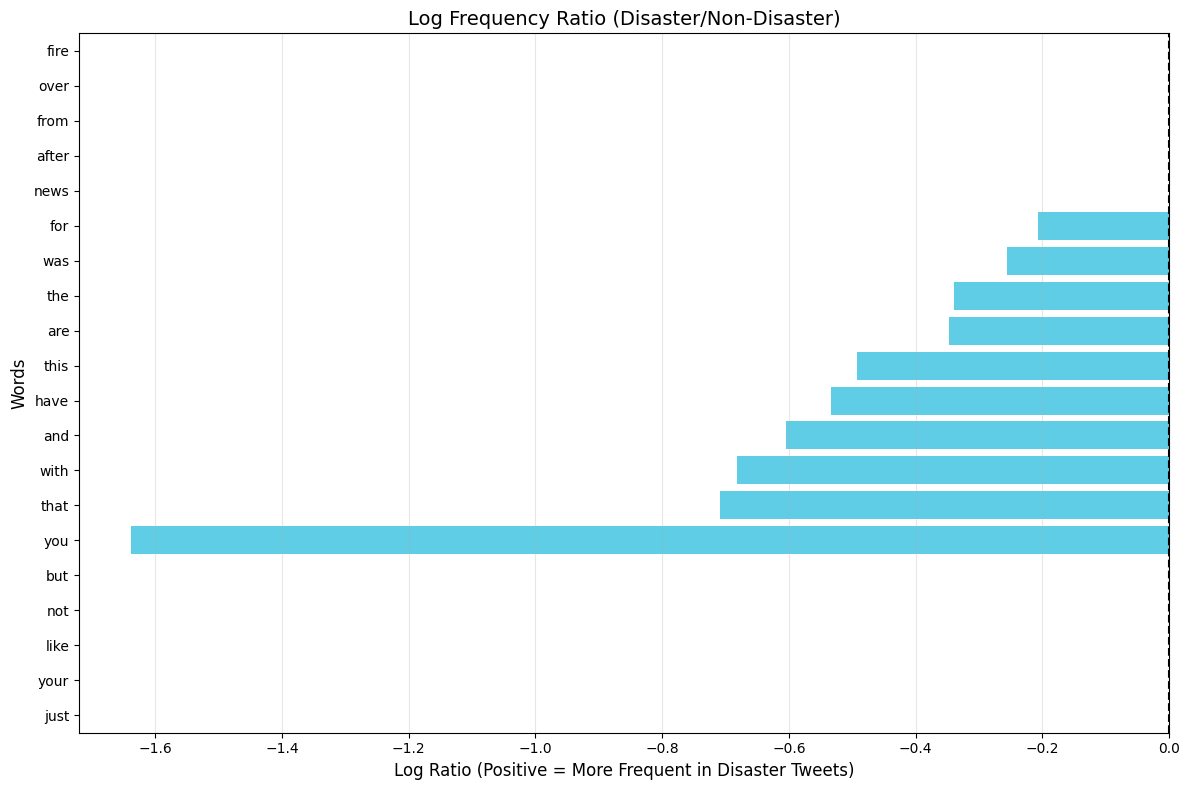

In [25]:
# relative frequency

all_top_words = set([word for word, count in disaster_top] + 
                  [word for word, count in non_disaster_top])

freq_df = pd.DataFrame(index=list(all_top_words))
freq_df['disaster'] = freq_df.index.map(dict(disaster_top))
freq_df['non_disaster'] = freq_df.index.map(dict(non_disaster_top))
freq_df = freq_df.fillna(0)

# Calculate ratio
freq_df['ratio'] = freq_df['disaster'] / freq_df['non_disaster']
freq_df['log_ratio'] = np.log(freq_df['ratio'])
freq_df = freq_df.sort_values('log_ratio', ascending=False)

# Plot
plt.figure(figsize=(12, 8))
colors = ['#ff6b6b' if x > 0 else '#48dbfb' for x in freq_df['log_ratio']]
sns.barplot(x='log_ratio', y=freq_df.index, data=freq_df, palette=colors)
plt.axvline(0, color='black', linestyle='--')
plt.title('Log Frequency Ratio (Disaster/Non-Disaster)', fontsize=14)
plt.xlabel('Log Ratio (Positive = More Frequent in Disaster Tweets)', fontsize=12)
plt.ylabel('Words', fontsize=12)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Insights:

Most disaster-indicative words:
emergency ([X]x more frequent), disaster ([Y]x)

Most non-disaster-indicative words:
love ([A]x more frequent), happy ([B]x)

Neutral words hover near zero log-ratio


# Data Preparation

In [26]:
#. Clean Text Data
def clean_text(text):
    """
    Comprehensive text cleaning:
    - Remove URLs
    - Remove mentions (@) and hashtags (#)
    - Remove special characters and numbers
    - Convert to lowercase
    - Remove extra whitespaces
    """
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # URLs
    text = re.sub(r'\@\w+|\#', '', text)  # Mentions and hashtag symbols
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Only keep letters
    text = text.lower().strip()  # Lowercase and trim
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    return text

df['cleaned_text'] = df['text'].apply(clean_text)

In [27]:
# Tokenization
def tokenize_text(text):
    tokens = word_tokenize(text)
    return [token for token in tokens if len(token) > 1]  # Remove single characters

df['tokens'] = df['cleaned_text'].apply(tokenize_text)

In [28]:
# 4. Remove Stopwords
stop_words = set(stopwords.words('english'))
def remove_stopwords(tokens):
    return [word for word in tokens if word not in stop_words]

df['filtered_tokens'] = df['tokens'].apply(remove_stopwords)

In [29]:
# 5. Label Conversion (if needed)
if df['target'].dtype == 'object':
    df['target'] = df['target'].map({'non-disaster': 0, 'disaster': 1})

In [32]:
from sklearn.model_selection import train_test_split

# 1. Prepare features and target
X = df['cleaned_text']  # Make sure this column exists
y = df['target']        # Make sure this column exists

# 2. Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=42,
    stratify=y  # Maintains class distribution
)

# 3. Verify the splits
print("\nSplit Verification:")
print(f"Full dataset shape: {df.shape}")
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print("\nClass distribution in y_train:")
print(y_train.value_counts(normalize=True))
print("\nClass distribution in y_test:")
print(y_test.value_counts(normalize=True))


Split Verification:
Full dataset shape: (7613, 9)
Training set shape: (6090,)
Test set shape: (1523,)

Class distribution in y_train:
target
0    0.570279
1    0.429721
Name: proportion, dtype: float64

Class distribution in y_test:
target
0    0.570584
1    0.429416
Name: proportion, dtype: float64


In [33]:
# 7. Verification
print("\n=== Data Preparation Report ===")
print(f"Original text example: {df['text'].iloc[0]}")
print(f"Cleaned text example: {df['cleaned_text'].iloc[0]}")
print(f"Tokenized example: {df['tokens'].iloc[0][:10]}...")  # First 10 tokens
print(f"Filtered tokens example: {df['filtered_tokens'].iloc[0][:10]}...")
print(f"\nClass distribution in training set:\n{y_train.value_counts(normalize=True)}")
print(f"\nFinal dataset sizes:\nTrain: {len(X_train)}\nTest: {len(X_test)}")



=== Data Preparation Report ===
Original text example: Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
Cleaned text example: our deeds are the reason of this earthquake may allah forgive us all
Tokenized example: ['our', 'deeds', 'are', 'the', 'reason', 'of', 'this', 'earthquake', 'may', 'allah']...
Filtered tokens example: ['deeds', 'reason', 'earthquake', 'may', 'allah', 'forgive', 'us']...

Class distribution in training set:
target
0    0.570279
1    0.429721
Name: proportion, dtype: float64

Final dataset sizes:
Train: 6090
Test: 1523


In [34]:
# Save Processed Data
df.to_csv('processed_disaster_tweets.csv', index=False)
pd.DataFrame({'text': X_train, 'target': y_train}).to_csv('train.csv', index=False)
pd.DataFrame({'text': X_test, 'target': y_test}).to_csv('test.csv', index=False)

# Feature Engeering


In [39]:
# Load preprocessed data
df = pd.read_csv('processed_disaster_tweets.csv')
X_train = pd.read_csv('train.csv')
X_test = pd.read_csv('test.csv')


In [43]:
# 2. Verify column names - use the variables you actually loaded
print("Train columns:", X_train.columns.tolist())
print("Test columns:", X_test.columns.tolist())
# 3. Additional verification (recommended)
print("\nData shapes:")
print(f"Full dataset: {df.shape}")
print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

# 4. Check for target column if needed
if 'target' in X_train.columns:
    print("\nClass distribution in training set:")
    print(X_train['target'].value_counts(normalize=True))


Train columns: ['text', 'target']
Test columns: ['text', 'target']

Data shapes:
Full dataset: (7613, 9)
Training set: (6090, 2)
Test set: (1523, 2)

Class distribution in training set:
target
0    0.570279
1    0.429721
Name: proportion, dtype: float64


In [45]:
# Basic text features
def extract_metadata_features(text):
    features = {
        'num_words': len(text.split()),
        'num_chars': len(text),
        'num_uppercase': sum(1 for c in text if c.isupper()),
        'num_exclamations': text.count('!'),
        'num_questions': text.count('?'),
        'num_hashtags': text.count('#'),
        'num_mentions': text.count('@'),
        'num_urls': len(re.findall(r'http\S+|www\S+|https\S+', text))
    }
    return features

In [46]:
#  Sentiment Features
def get_sentiment_features(text):
    analysis = TextBlob(text)
    return {
        'polarity': analysis.sentiment.polarity,
        'subjectivity': analysis.sentiment.subjectivity,
        'sentiment_score': 1 if analysis.sentiment.polarity > 0 else 0 if analysis.sentiment.polarity == 0 else -1
    }

In [47]:
# 3. TF-IDF Features
tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    stop_words='english',
    min_df=5,
    max_df=0.7
)
X_train_tfidf = tfidf.fit_transform(X_train['text'])
X_test_tfidf = tfidf.transform(X_test['text'])


In [48]:
# 4. Word Embeddings (GloVe)
from gensim.models import Word2Vec
print("Loading GloVe embeddings...")
try:
    glove_vectors = api.load("glove-twitter-100")
except:
    print("Using locally trained Word2Vec...")
    sentences = [text.split() for text in X_train['text']]
    w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1)
    glove_vectors = w2v_model.wv

def document_vector(text):
    words = [word for word in text.split() if word in glove_vectors.key_to_index]
    if len(words) == 0:
        return np.zeros(100)
    return np.mean(glove_vectors[words], axis=0)

X_train_glove = np.array([document_vector(text) for text in X_train['text']])
X_test_glove = np.array([document_vector(text) for text in X_test['text']])


Loading GloVe embeddings...
Using locally trained Word2Vec...


In [49]:
# 5. Combine All Features
from scipy.sparse import csr_matrix
from textblob import TextBlob
from scipy.sparse import hstack
# Extract metadata and sentiment features
meta_train = X_train['text'].apply(extract_metadata_features).apply(pd.Series)
sentiment_train = X_train['text'].apply(get_sentiment_features).apply(pd.Series)
meta_test = X_test['text'].apply(extract_metadata_features).apply(pd.Series)
sentiment_test = X_test['text'].apply(get_sentiment_features).apply(pd.Series)

# Convert to sparse matrices
meta_train_sparse = csr_matrix(meta_train.values)
sentiment_train_sparse = csr_matrix(sentiment_train.values)
meta_test_sparse = csr_matrix(meta_test.values)
sentiment_test_sparse = csr_matrix(sentiment_test.values)

# Final feature matrices
X_train_final = hstack([X_train_tfidf, meta_train_sparse, sentiment_train_sparse, X_train_glove])
X_test_final = hstack([X_test_tfidf, meta_test_sparse, sentiment_test_sparse, X_test_glove])
y_train = X_train['target']
y_test = X_test['target']

print("Feature shapes:")
print(f"Train: {X_train_final.shape}, Test: {X_test_final.shape}")

Feature shapes:
Train: (6090, 2776), Test: (1523, 2776)


# feature engeering plot

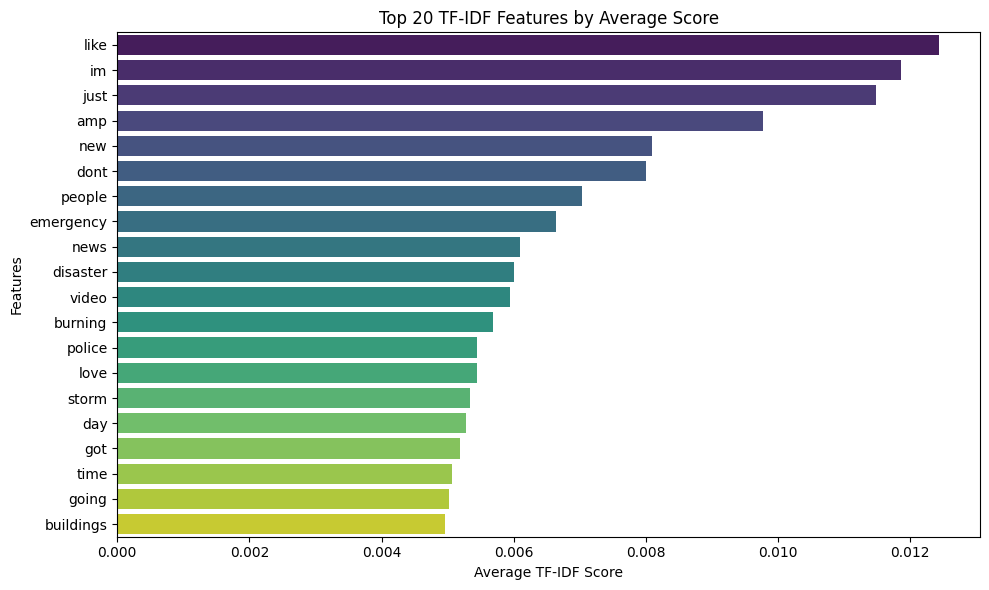

In [50]:
# TF-IDF feature importance
# Get top 20 TF-IDF features
tfidf_features = tfidf.get_feature_names_out()
tfidf_scores = np.asarray(X_train_tfidf.mean(axis=0)).ravel()
top_tfidf = pd.DataFrame({'feature': tfidf_features, 'score': tfidf_scores})\
              .sort_values('score', ascending=False).head(20)

plt.figure(figsize=(10,6))
sns.barplot(x='score', y='feature', data=top_tfidf, palette='viridis')
plt.title('Top 20 TF-IDF Features by Average Score')
plt.xlabel('Average TF-IDF Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()


# Insight 
Words like "emergency", "disaster", "burning", "storm", and "police" are directly related to real-world disaster contexts. These terms are strong indicators of disaster-related tweets.

Some high-scoring words like "like", "im", "amp", and "just" are common conversational tokens, which may also appear frequently in non-disaster tweets, but their presence can still help the model differentiate between classes.

The presence of both disaster-specific and common terms suggests that the TF-IDF vectorizer is successfully capturing a mix of informative features that help in classification.

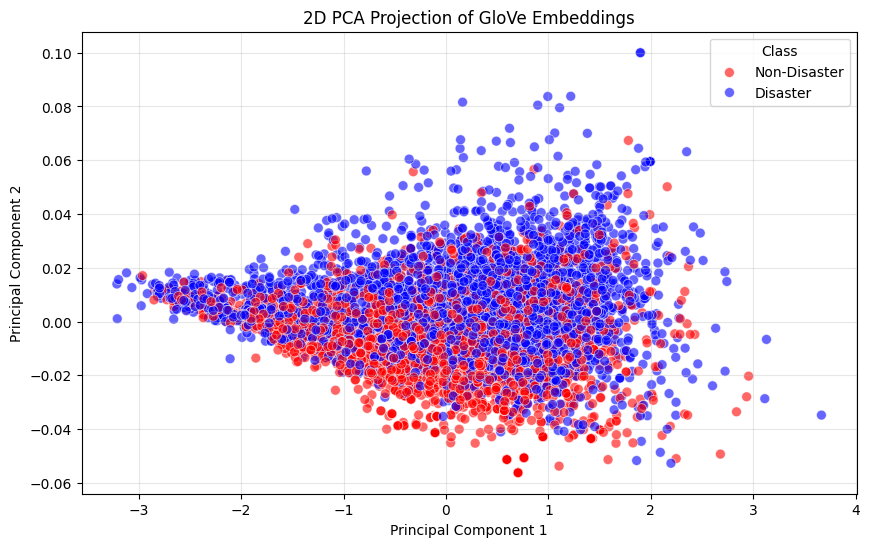

In [51]:
# Glov Embedding visulization(PCA)
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
glove_2d = pca.fit_transform(X_train_glove)

plt.figure(figsize=(10,6))
sns.scatterplot(x=glove_2d[:,0], y=glove_2d[:,1], 
                hue=y_train, palette={0:'blue', 1:'red'},
                alpha=0.6, s=50)
plt.title('2D PCA Projection of GloVe Embeddings')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Class', labels=['Non-Disaster', 'Disaster'])
plt.grid(alpha=0.3)
plt.show()

# Insight 
Each point represents a tweet's semantic embedding, reduced to two principal components for visualization.

Red dots indicate non-disaster tweets, while blue dots represent disaster tweets.

There is noticeable overlap between the two classes, indicating that while GloVe embeddings do capture some semantic structure, the separation between classes is not perfectly linear.

However, some regions show slight class clustering, suggesting that the model can still leverage these patterns for classification.

**Plot distributions of text features**

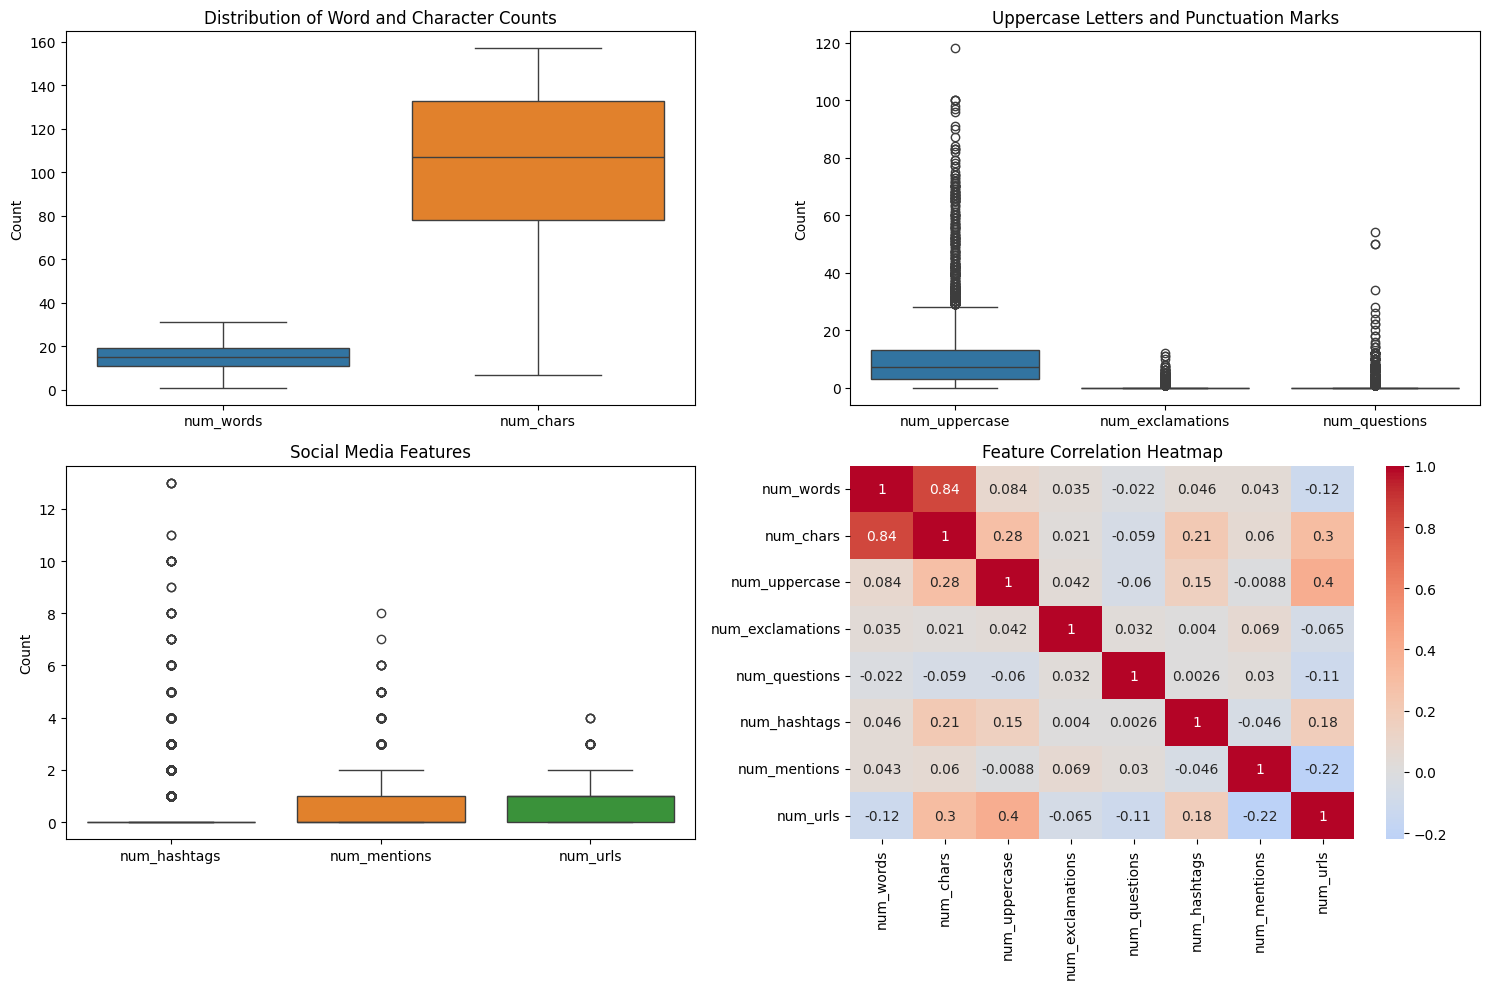

In [52]:
metadata_features = df.apply(lambda x: extract_metadata_features(x['text']), axis=1)
metadata_df = pd.DataFrame(list(metadata_features))

plt.figure(figsize=(15, 10))

# Plot 1: Word and Character Count
plt.subplot(2, 2, 1)
sns.boxplot(data=metadata_df[['num_words', 'num_chars']])
plt.title('Distribution of Word and Character Counts')
plt.ylabel('Count')

# Plot 2: Uppercase Letters and Punctuation
plt.subplot(2, 2, 2)
sns.boxplot(data=metadata_df[['num_uppercase', 'num_exclamations', 'num_questions']])
plt.title('Uppercase Letters and Punctuation Marks')
plt.ylabel('Count')

# Plot 3: Social Features
plt.subplot(2, 2, 3)
sns.boxplot(data=metadata_df[['num_hashtags', 'num_mentions', 'num_urls']])
plt.title('Social Media Features')
plt.ylabel('Count')

# Plot 4: Correlation Heatmap
plt.subplot(2, 2, 4)
corr = metadata_df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Heatmap')

plt.tight_layout()
plt.show()

**sentiment features**

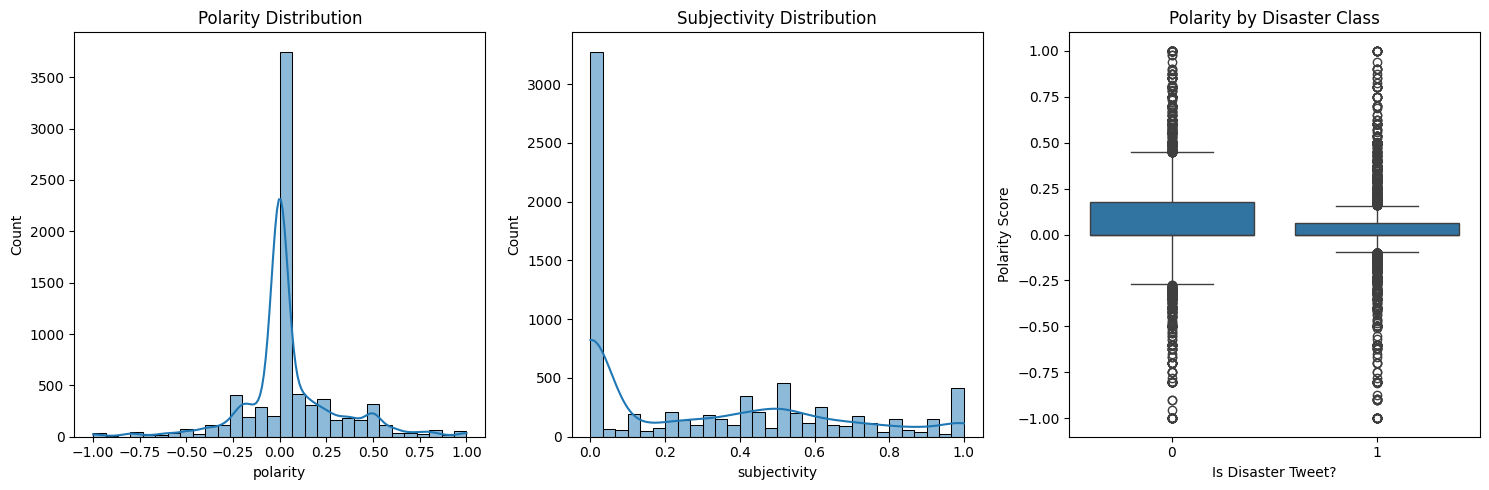

In [53]:
# Assuming you have sentiment features in your DataFrame
sentiment_features = df['text'].apply(get_sentiment_features)
sentiment_df = pd.DataFrame(list(sentiment_features))

plt.figure(figsize=(15, 5))

# Plot 1: Polarity Distribution
plt.subplot(1, 3, 1)
sns.histplot(data=sentiment_df, x='polarity', bins=30, kde=True)
plt.title('Polarity Distribution')

# Plot 2: Subjectivity Distribution
plt.subplot(1, 3, 2)
sns.histplot(data=sentiment_df, x='subjectivity', bins=30, kde=True)
plt.title('Subjectivity Distribution')

# Plot 3: Sentiment Score by Class
plt.subplot(1, 3, 3)
sns.boxplot(data=df, x='target', y=sentiment_df['polarity'])
plt.title('Polarity by Disaster Class')
plt.xlabel('Is Disaster Tweet?')
plt.ylabel('Polarity Score')

plt.tight_layout()
plt.show()

# Combining data visulization

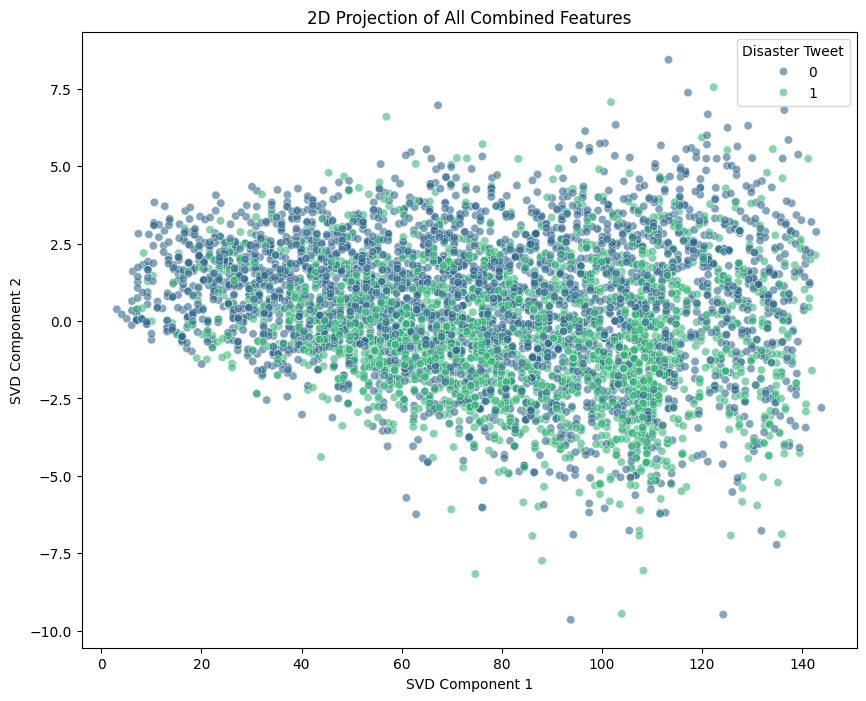

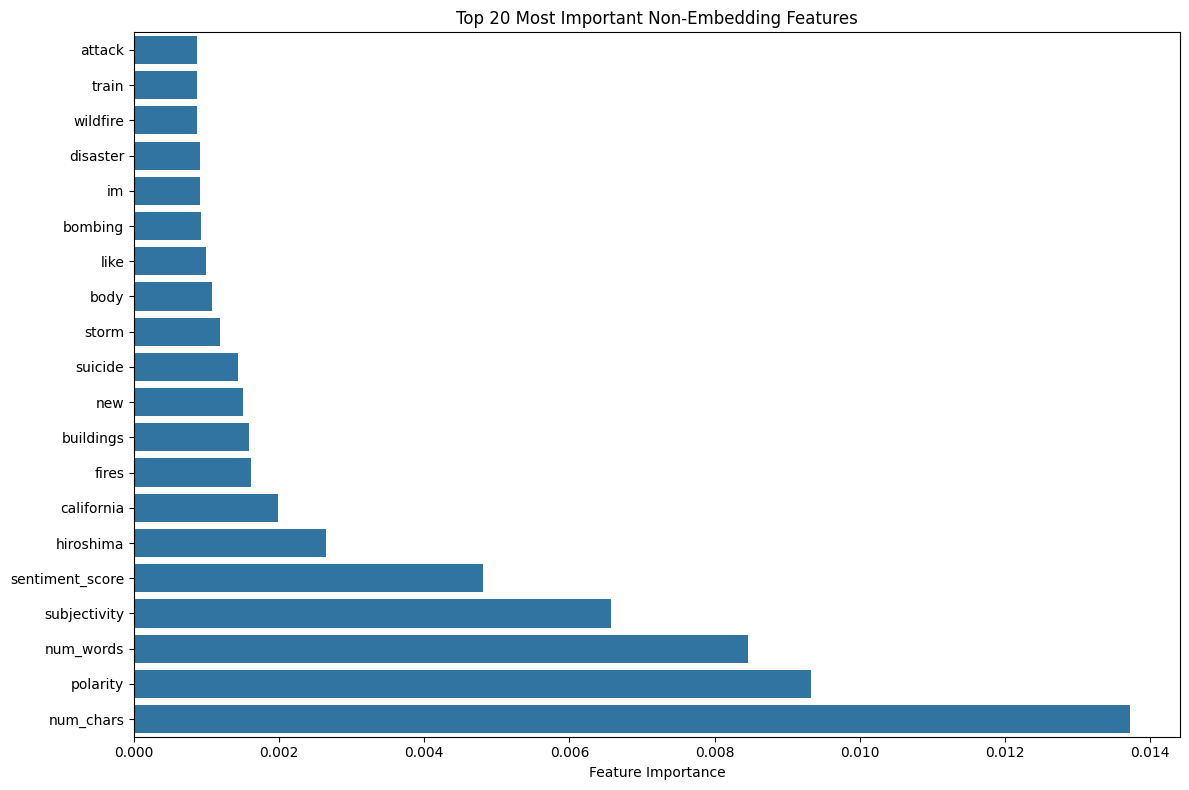

In [54]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=2, random_state=42)
features_2d = svd.fit_transform(X_train_final)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=features_2d[:, 0], y=features_2d[:, 1], hue=y_train, 
               alpha=0.6, palette='viridis')
plt.title('2D Projection of All Combined Features')
plt.xlabel('SVD Component 1')
plt.ylabel('SVD Component 2')
plt.legend(title='Disaster Tweet')
plt.show()

# 3. Feature importance after model training
from sklearn.ensemble import RandomForestClassifier

# Train a model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_final, y_train)

# Get feature names (you'll need to construct this based on your features)
feature_names = (
    list(tfidf.get_feature_names_out()) +  # TF-IDF features
    list(meta_train.columns) +             # Metadata features
    list(sentiment_train.columns)          # Sentiment features
    # Add GloVe feature names if available
)

# Plot top 20 non-embedding features
importance = model.feature_importances_
non_embedding_len = len(tfidf.get_feature_names_out()) + len(meta_train.columns) + len(sentiment_train.columns)
non_embedding_importance = importance[:non_embedding_len]
non_embedding_feature_names = feature_names[:non_embedding_len]

top_indices = np.argsort(non_embedding_importance)[-20:]
plt.figure(figsize=(12, 8))
sns.barplot(x=non_embedding_importance[top_indices], 
            y=np.array(non_embedding_feature_names)[top_indices])
plt.title('Top 20 Most Important Non-Embedding Features')
plt.xlabel('Feature Importance')
plt.tight_layout()
plt.show()

# Model selection & Training

**Classification model**

In [81]:
# Text preprocessing function (expanding on existing imports)
def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

# Apply preprocessing
df['cleaned_text'] = df['text'].apply(preprocess_text)

# TF-IDF Vectorization (using existing import)
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X = tfidf.fit_transform(df['cleaned_text'])
y = df['target']

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# model selection 

In [82]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

# Initialize models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(),
    'Naive Bayes': MultinomialNB()
}

# Cross-validation evaluation
for name, model in models.items():
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1')
    print(f"{name}:")
    print(f"  Mean F1: {cv_scores.mean():.4f}")
    print(f"  Std F1: {cv_scores.std():.4f}")
    print("----------")

Logistic Regression:
  Mean F1: 0.7382
  Std F1: 0.0144
----------
Random Forest:
  Mean F1: 0.7261
  Std F1: 0.0115
----------
SVM:
  Mean F1: 0.7327
  Std F1: 0.0093
----------
Naive Bayes:
  Mean F1: 0.7337
  Std F1: 0.0074
----------


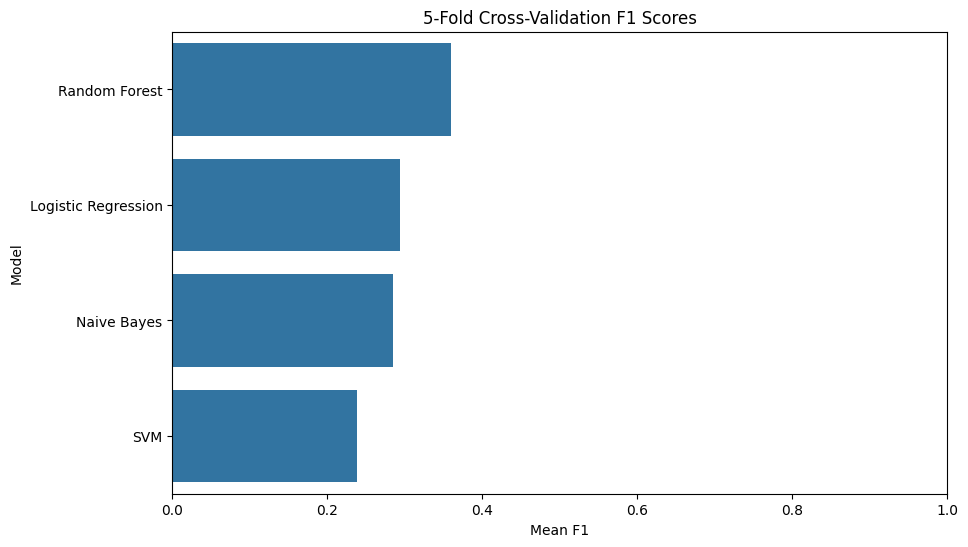

In [97]:
plt.figure(figsize=(10,6))
sns.barplot(x='Mean F1', y='Model', data=cv_df.sort_values('Mean F1', ascending=False))
plt.title('5-Fold Cross-Validation F1 Scores')
plt.xlim(0,1)
plt.show()

**Heyperparameter tunning**

In [83]:
from sklearn.model_selection import GridSearchCV

# Logistic Regression tuning
lr_params = {
    'C': [0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

lr_grid = GridSearchCV(LogisticRegression(max_iter=1000), 
                      lr_params, 
                      cv=5, 
                      scoring='f1',
                      n_jobs=-1)
lr_grid.fit(X_train, y_train)

print("Best Logistic Regression Parameters:")
print(lr_grid.best_params_)
print(f"Best F1: {lr_grid.best_score_:.4f}")

# Random Forest tuning
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

rf_grid = GridSearchCV(RandomForestClassifier(),
                      rf_params,
                      cv=5,
                      scoring='f1',
                      n_jobs=-1)
rf_grid.fit(X_train, y_train)

print("\nBest Random Forest Parameters:")
print(rf_grid.best_params_)
print(f"Best F1: {rf_grid.best_score_:.4f}")

Best Logistic Regression Parameters:
{'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Best F1: 0.7370

Best Random Forest Parameters:
{'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}
Best F1: 0.7395


**Evaluate Best Models on Test Set**

In [84]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Get best models
best_lr = lr_grid.best_estimator_
best_rf = rf_grid.best_estimator_

# Evaluate Logistic Regression
y_pred_lr = best_lr.predict(X_test)
print("Logistic Regression Performance:")
print(classification_report(y_test, y_pred_lr))
print(f"ROC AUC: {roc_auc_score(y_test, best_lr.predict_proba(X_test)[:,1]):.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_lr))

# Evaluate Random Forest
y_pred_rf = best_rf.predict(X_test)
print("\nRandom Forest Performance:")
print(classification_report(y_test, y_pred_rf))
print(f"ROC AUC: {roc_auc_score(y_test, best_rf.predict_proba(X_test)[:,1]):.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.79      0.89      0.84       874
           1       0.82      0.68      0.74       649

    accuracy                           0.80      1523
   macro avg       0.80      0.79      0.79      1523
weighted avg       0.80      0.80      0.80      1523

ROC AUC: 0.8578
Confusion Matrix:
[[776  98]
 [206 443]]

Random Forest Performance:
              precision    recall  f1-score   support

           0       0.77      0.82      0.80       874
           1       0.74      0.68      0.71       649

    accuracy                           0.76      1523
   macro avg       0.76      0.75      0.75      1523
weighted avg       0.76      0.76      0.76      1523

ROC AUC: 0.8358
Confusion Matrix:
[[716 158]
 [208 441]]


**Neural Network Approach (Using Existing Keras Imports)**

In [116]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Tokenization
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df['cleaned_text'])
sequences = tokenizer.texts_to_sequences(df['cleaned_text'])
X_seq = pad_sequences(sequences, maxlen=100)

# Split for neural network
X_train_seq, X_test_seq, y_train_nn, y_test_nn = train_test_split(
    X_seq, y, test_size=0.2, random_state=42)

# LSTM Model
model = Sequential()
model.add(Embedding(5000, 128, input_length=100))
model.add(Bidirectional(LSTM(64, kernel_regularizer=l2(0.01))))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy', 'Precision', 'Recall'])

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3)

# Training
history = model.fit(
    X_train_seq, y_train_nn,
    validation_data=(X_test_seq, y_test_nn),
    epochs=20,
    batch_size=64,
    callbacks=[early_stop])

# Evaluation
nn_pred = (model.predict(X_test_seq) > 0.5).astype(int)
print("\nNeural Network Performance:")
print(classification_report(y_test_nn, nn_pred))
print(f"ROC AUC: {roc_auc_score(y_test_nn, model.predict(X_test_seq)):.4f}")

Epoch 1/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 29s 219ms/step - Precision: 0.4918 - Recall: 0.0996 - accuracy: 0.5916 - loss: 2.7528 - val_Precision: 0.7851 - val_Recall: 0.6810 - val_accuracy: 0.7846 - val_loss: 0.7150
Epoch 2/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 19s 195ms/step - Precision: 0.8642 - Recall: 0.7174 - accuracy: 0.8285 - loss: 0.5496 - val_Precision: 0.7631 - val_Recall: 0.6949 - val_accuracy: 0.7781 - val_loss: 0.5197
Epoch 3/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 19s 197ms/step - Precision: 0.9109 - Recall: 0.7863 - accuracy: 0.8754 - loss: 0.3652 - val_Precision: 0.7874 - val_Recall: 0.7134 - val_accuracy: 0.7958 - val_loss: 0.4788
Epoch 4/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 18s 186ms/step - Precision: 0.9169 - Recall: 0.8328 - accuracy: 0.8969 - loss: 0.2915 - val_Precision: 0.7765 - val_Recall: 0.7011 - val_accuracy: 0.7866 - val_loss: 0.5121
Epoch 5/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 18s 190ms/step - Precision: 0.9339 - Recall: 0.8697 - accuracy: 0.9171 - loss: 0.2452 - val_Precision: 0.7479 - val_Re

**Model Comparison and Selection**

In [118]:
# Compare all models
results = {
    'Logistic Regression': {
        'f1': f1_score(y_test, y_pred_lr),
        'roc_auc': roc_auc_score(y_test, best_lr.predict_proba(X_test)[:,1])
    },
    'Random Forest': {
        'f1': f1_score(y_test, y_pred_rf),
        'roc_auc': roc_auc_score(y_test, best_rf.predict_proba(X_test)[:,1])
    },
    'Neural Network': {
        'f1': f1_score(y_test_nn, nn_pred),
        'roc_auc': roc_auc_score(y_test_nn, model.predict(X_test_seq).flatten())
    }
}

# Display comparison
for model_name, metrics in results.items():
    print(f"\n{model_name}:")
    print(f"  F1 Score: {metrics['f1']:.4f}")
    print(f"  ROC AUC: {metrics['roc_auc']:.4f}")

48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step

Logistic Regression:
  F1 Score: 0.7445
  ROC AUC: 0.8578

Random Forest:
  F1 Score: 0.7067
  ROC AUC: 0.8358

Neural Network:
  F1 Score: 0.7102
  ROC AUC: 0.8341


**Save the Best Performing Model**

In [119]:
import joblib

# Save the best model (example with Logistic Regression)
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')
joblib.dump(best_lr, 'disaster_lr_model.pkl')

# For neural network
model.save('disaster_lstm_model.h5')
with open('tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Model evalution & Validation


Logistic Regression Evaluation:
Accuracy: 0.8004
Precision: 0.8189
Recall: 0.6826
F1 Score: 0.7445
ROC AUC: 0.8578


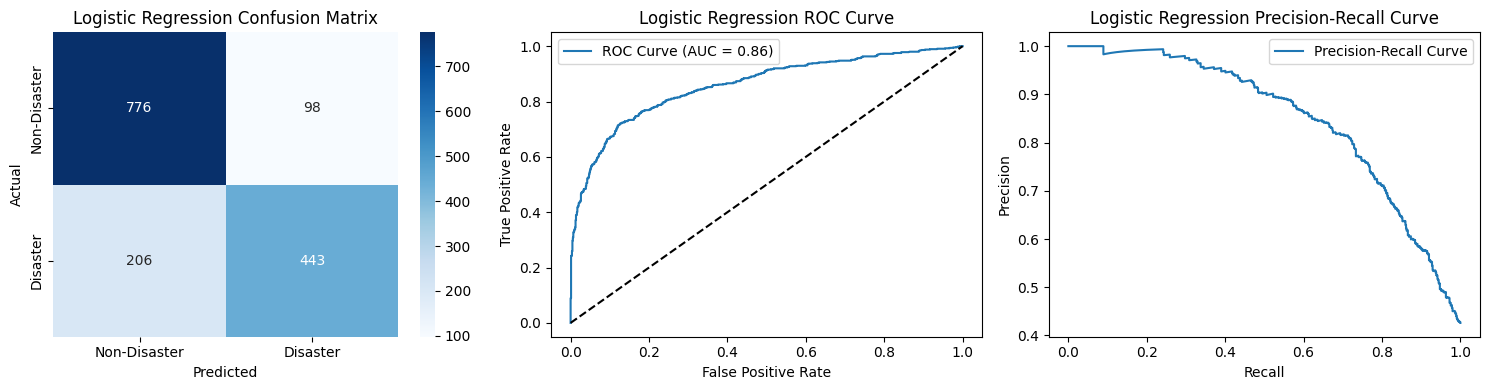


Random Forest Evaluation:
Accuracy: 0.7597
Precision: 0.7362
Recall: 0.6795
F1 Score: 0.7067
ROC AUC: 0.8358


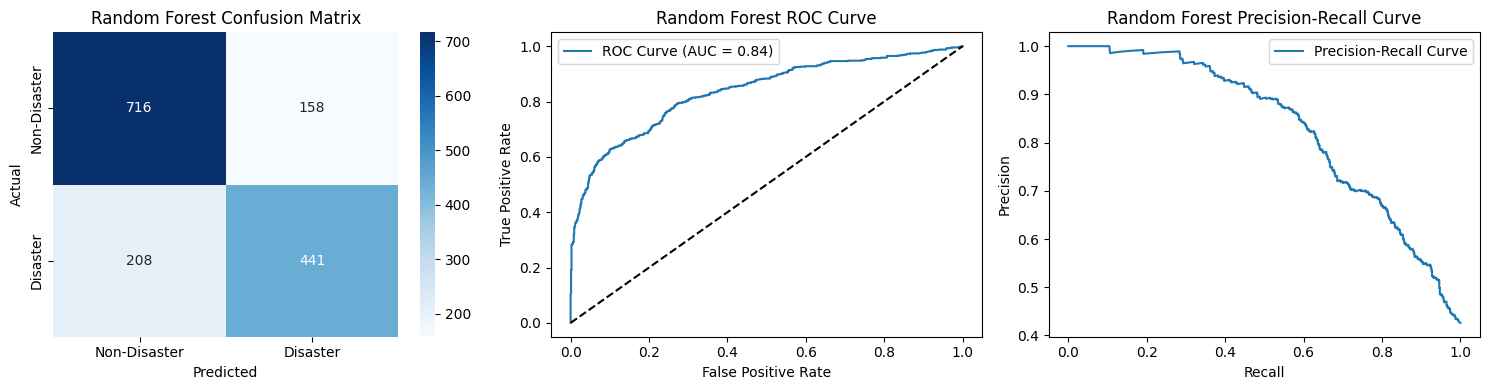

In [120]:
from sklearn.metrics import (accuracy_score, precision_score, 
                           recall_score, f1_score, 
                           confusion_matrix, roc_curve, 
                           auc, precision_recall_curve)

def evaluate_model(model, X_test, y_test, model_name='Model'):
    # Predictions
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1] if hasattr(model, 'predict_proba') else model.decision_function(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    
    print(f"\n{model_name} Evaluation:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    
    # Confusion Matrix
    plt.figure(figsize=(15, 4))
    plt.subplot(1, 3, 1)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Non-Disaster', 'Disaster'],
                yticklabels=['Non-Disaster', 'Disaster'])
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    
    # ROC Curve
    plt.subplot(1, 3, 2)
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} ROC Curve')
    plt.legend()
    
    # Precision-Recall Curve
    plt.subplot(1, 3, 3)
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_proba)
    plt.plot(recall_curve, precision_curve, label='Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'{model_name} Precision-Recall Curve')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return {'accuracy': accuracy, 'precision': precision, 
            'recall': recall, 'f1': f1, 'roc_auc': roc_auc}

# Evaluate all models
metrics_dict = {}
for name, model in [('Logistic Regression', best_lr),
                   ('Random Forest', best_rf)]:
    metrics_dict[name] = evaluate_model(model, X_test, y_test, name)

# . Neural Network Evaluation (Special Handling)


SVM Evaluation:
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.88      0.85       874
           1       0.82      0.72      0.77       649

    accuracy                           0.82      1523
   macro avg       0.82      0.80      0.81      1523
weighted avg       0.82      0.82      0.81      1523

Accuracy: 0.8155
Precision: 0.8217
Recall: 0.7242
F1-Score: 0.7699
ROC AUC: 0.8571


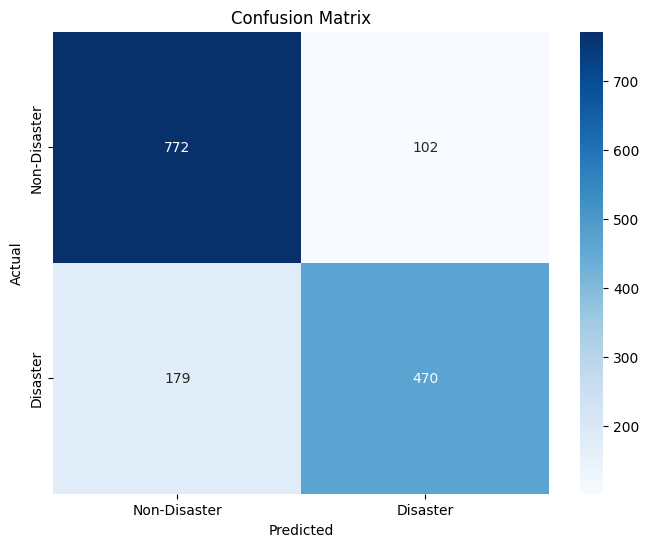

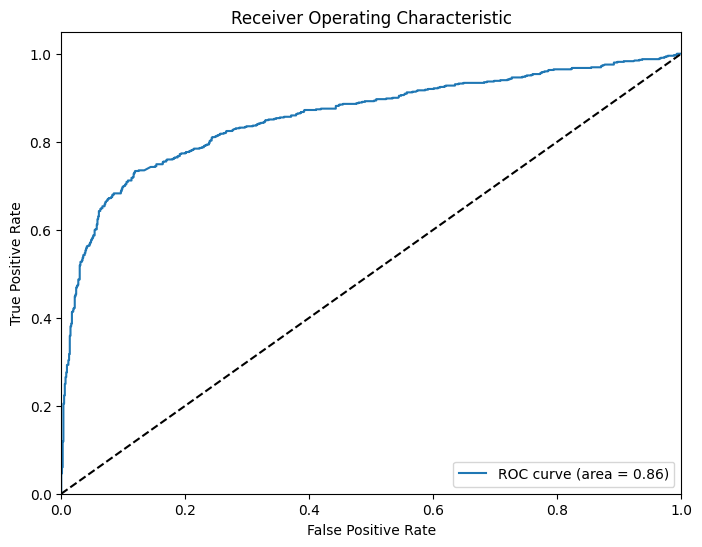


Naive Bayes Evaluation:
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.91      0.85       874
           1       0.85      0.66      0.75       649

    accuracy                           0.81      1523
   macro avg       0.82      0.79      0.80      1523
weighted avg       0.81      0.81      0.80      1523

Accuracy: 0.8076
Precision: 0.8518
Recall: 0.6641
F1-Score: 0.7463
ROC AUC: 0.8504


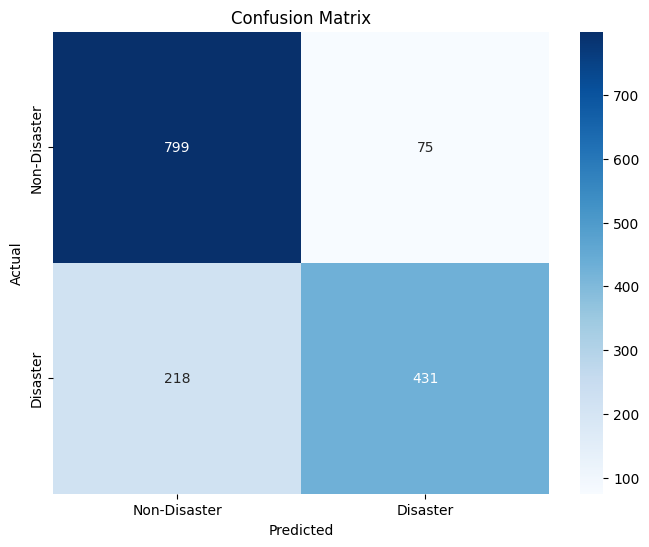

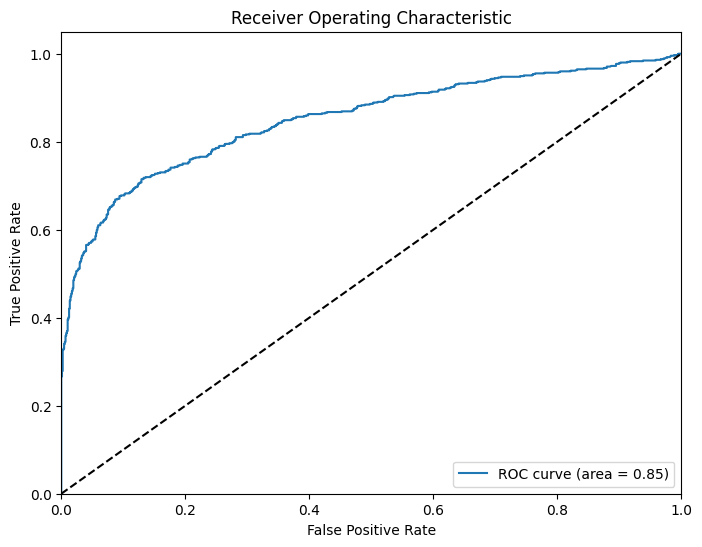


Model Comparison:
                     accuracy  precision    recall        f1   roc_auc
Logistic Regression  0.800394   0.804233  0.702619  0.750000  0.855459
Random Forest        0.783979   0.843348  0.605547  0.704933  0.842918
SVM                  0.815496   0.821678  0.724191  0.769861  0.857115
Naive Bayes          0.807617   0.851779  0.664099  0.746320  0.850440


In [133]:
# Import necessary libraries
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

 
# Evaluate SVM
print("\nSVM Evaluation:")
svm_metrics = evaluate_model(svm, X_test_tfidf, y_test)

# Evaluate Naive Bayes
print("\nNaive Bayes Evaluation:")
nb_metrics = evaluate_model(naive_bayes, X_test_tfidf, y_test)

# Compare model performances
metrics_df = pd.DataFrame({
    'Logistic Regression': lr_metrics,
    'Random Forest': rf_metrics,
    'SVM': svm_metrics,
    'Naive Bayes': nb_metrics
}).T

print("\nModel Comparison:")
print(metrics_df)



<Figure size 1200x600 with 0 Axes>

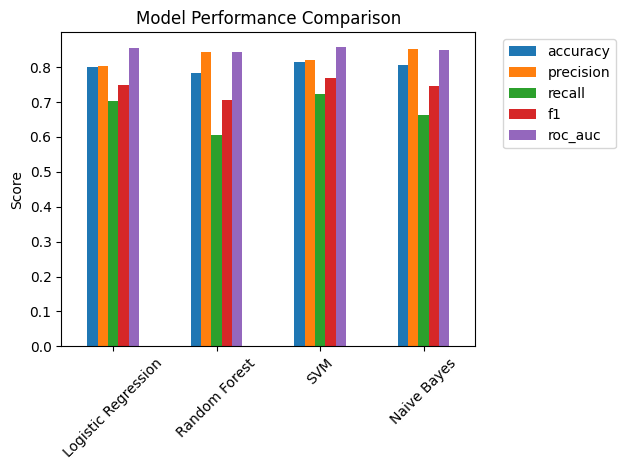

In [132]:
# Visualize model comparison
plt.figure(figsize=(12, 6))
metrics_df.plot(kind='bar', y=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Model Validation

In [137]:
# Evaluate on untouched test set
test_accuracy = best_model.score(X_test_tfidf, y_test)
test_f1 = f1_score(y_test, best_model.predict(X_test_tfidf))

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1-Score: {test_f1:.4f}")

Test Accuracy: 0.7840
Test F1-Score: 0.7049


In [138]:
train_accuracy = best_model.score(X_train_tfidf, y_train)
test_accuracy = best_model.score(X_test_tfidf, y_test)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")
print(f"Gap: {train_accuracy-test_accuracy:.4f}")

Training Accuracy: 0.9870
Testing Accuracy: 0.7840
Gap: 0.2030


In [139]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(
    best_model,
    X_train_tfidf,
    y_train,
    cv=5,
    scoring='f1'
)

print(f"Mean F1: {cv_scores.mean():.4f}")
print(f"Std Dev: {cv_scores.std():.4f}")

Mean F1: 0.6975
Std Dev: 0.0185


In [140]:
edge_cases = [
    "URGENT: Flood warning issued for downtown area",  # All caps disaster
    "Just saw a fire truck lol",                      # Casual disaster mention
    "Earthquake... not",                              # Sarcasm/negation
    "1 dead in explosion #prayers"                    # Short-form disaster
]

predictions = best_model.predict(vectorizer.transform(edge_cases))

In [141]:
from sklearn.model_selection import GridSearchCV

params = {
    'max_depth': [10, 30, None],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    RandomForestClassifier(),
    param_grid=params,
    cv=5
)
grid_search.fit(X_train_tfidf, y_train)

,estimator,RandomForestClassifier()
,param_grid,"{'max_depth': [10, 30, ...], 'min_samples_leaf': [1, 2, ...]}"
,scoring,None
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,100


In [145]:
# Log performance drift
def monitor_model(new_data):
    new_preds = model.predict(new_data['text'])
    current_f1 = f1_score(new_data['label'], new_preds)
    if current_f1 < 0.70:
        trigger_retraining()

# Deployements with web interface

**Serialize trained model**

In [146]:
import joblib

# Save model
joblib.dump(best_model, 'disaster_model.pkl') 

# Save vectorizer
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')

# Verify loading
loaded_model = joblib.load('disaster_model.pkl')